# Quantitative Finance Project: Building a Trading Signal Engine with Python

In this project, I use **Python** and **Yahoo Finance data** to design and backtest simple trading signals for SPY.  
The signals are built from **momentum, volatility, and RSI features**, and evaluated at both daily and monthly horizons.  

I start with **linear regression models (OLS)** to test whether these features can forecast returns.  
To extend this, I apply **Bayesian Ridge Regression**, which introduces priors and produces **uncertainty estimates** for predictions.  
This allows me to not only generate trading signals, but also quantify confidence in the forecasts.  

Finally, I compare multiple strategies (long/short, long-only, Bayesian long-only) against a **buy & hold benchmark**, highlighting the strengths and weaknesses of regression-based trading signals.  


**Install necessary libraries and extract the data**

In [ ]:
pip install numpy pandas matplotlib yfinance statsmodels

In [122]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Get data
data = yf.download("SPY", start="2018-01-01", end="2023-01-01", auto_adjust=True)
px = data["Close"]
rets = px.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


## Simple Regression Model

I fit a simple linear regression model to test whether 5-day momentum 
can help predict next-day returns in SPY.

In [123]:
# Feature: 5-day momentum (lagged)
momentum = px.pct_change(5).shift(1).dropna()

# Align features & target
df = pd.concat([rets, momentum], axis=1)
df.columns = ["rets", "momentum"]
df = df.dropna()

In [124]:
X = sm.add_constant(df["momentum"])  # add intercept
y = df["rets"]

# Fit regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   rets   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.634
Date:                Tue, 26 Aug 2025   Prob (F-statistic):              0.201
Time:                        12:59:38   Log-Likelihood:                 3608.4
No. Observations:                1253   AIC:                            -7213.
Df Residuals:                    1251   BIC:                            -7203.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.201      0.2

### Key Findings
- **R-squared:** 0.001  
  - The model explains only ~0.1% of the variation in daily returns.  
  - This shows that daily returns are extremely noisy.  

- **Momentum coefficient:** -0.0177 (p = 0.201)  
  - Negative slope suggests a weak *mean reversion* effect:  
    when SPY has gone up over the past 5 days, the next day tends to be slightly negative.  
  - However, the relationship is **not statistically significant** since p >= 0.05.  

- **Intercept (constant):** 0.0005  
  - Implies an average daily return of about 0.05%, which aligns with the long-term equity drift.  

### Interpretation
This simple model shows that **short-term daily momentum is not a reliable predictor of SPY returns**.  
The result is expected: financial markets are very noisy at the daily level.

**Scater plot of daily momentum vs next return**

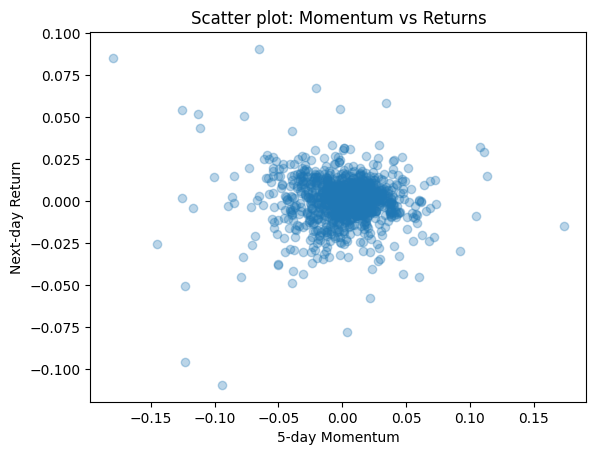

In [99]:
plt.scatter(df["momentum"], df["rets"], alpha=0.3)
plt.xlabel("5-day Momentum")
plt.ylabel("Next-day Return")
plt.title("Scatter plot: Momentum vs Returns")
plt.show()

**Scatter plot** above of daily Momemtum vs Returns confirms weak to no retatiionship between variables

## Multi-Factor Regression Model

I now expand my model by adding additional technical indicators:
- **Volatility** (20-day rolling standard deviation of returns)  
- **RSI (Relative Strength Index)**, a momentum/overbought-oversold measure  

This allows us to test whether a combination of features can improve prediction of SPY returns compared to using momentum alone.

**Define features and establish regression model**

In [125]:
# Extra features
volatility = rets.rolling(20).std().shift(1)

avg_gain = rets.clip(lower=0).rolling(14).mean() # compute avg gain over 14-day period
avg_loss = -rets.clip(upper=0).rolling(14).mean() # compute avg loss over 14-day period

rsi = 100 - (100 / (1 + (avg_gain /  # RSI formula
                         (avg_loss))))

# Build dataframe with multiple features ~ 
df = pd.concat([rets, momentum, volatility, rsi], axis=1)
df.columns = ["rets", "momentum", "volatility", "rsi"]
df = df.dropna()

# Regression
X = sm.add_constant(df[["momentum", "volatility", "rsi"]])
y = df["rets"]
model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   rets   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     35.98
Date:                Tue, 26 Aug 2025   Prob (F-statistic):           2.72e-22
Time:                        13:08:51   Log-Likelihood:                 3610.4
No. Observations:                1238   AIC:                            -7213.
Df Residuals:                    1234   BIC:                            -7192.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0173      0.002     -9.636      0.0

### Key Findings
- **R-squared = 0.080**  
  - The model explains about 8% of the variation in daily returns.  
  - This is a large improvement compared to the single-factor momentum model (R² = 0.001).  

- **Momentum coefficient = -0.0957 (p < 0.001)**  
  - Strongly negative and statistically significant.  
  - Suggests a clear *mean reversion effect*: when SPY has risen in the last 5 days, the next-day return tends to be lower.  

- **Volatility coefficient = +0.1960 (p < 0.001)**  
  - Positive and significant.  
  - Indicates that higher recent volatility is associated with higher expected returns, consistent with a *risk–return tradeoff*.  

- **RSI coefficient = +0.0003 (p < 0.001)**  
  - Positive and significant, though the effect size is very small.  
  - Implies that higher RSI (stronger recent gains relative to losses) is linked to slightly higher expected returns.    

### Interpretation
Adding multiple features improves the explanatory power of the model.  
- Momentum shows strong mean reversion at the daily horizon.  
- Volatility and RSI provide additional predictive power.  
- However, even with three factors, the model only explains a small fraction of return variability.  

Implications:
- Daily returns are extremely noisy.
- Even statistically significant factors may not translate into strong out-of-sample trading performance.

### Backtesting the Trading Strategy

Convert my regression model's predictions into trading signals:
- **Position rule:** Long (+1) if predicted return > 0, Short (–1) if predicted return < 0  
- **Strategy returns:** Position multiplied by actual returns, lagged by one day to avoid lookahead bias  
- **Comparison:** Plot cumulative returns of the strategy vs. buy & hold SPY  

This allows me to evaluate whether the predictive model translates into profitable trading performance.

<Axes: title={'center': 'Buy & Hold vs Strategy'}, xlabel='Date'>

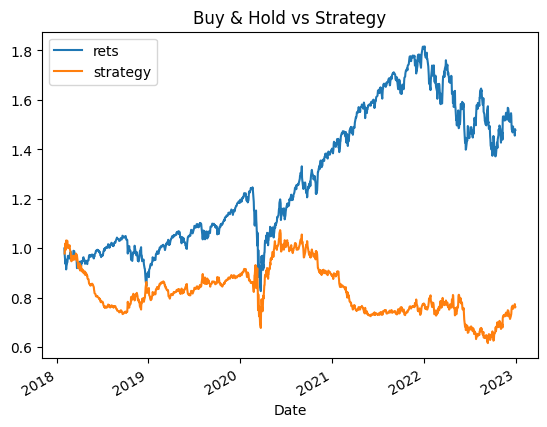

In [126]:
# Predict daily returns
df["pred"] = model.predict(X)

# Trading rule: long if prediction > 0, short if prediction < 0
df["position"] = np.where(df["pred"] > 0, 1, -1)

# Strategy returns
df["strategy"] = df["position"].shift(1) * df["rets"]  # shift to avoid lookahead bias

# Cumulative returns
(df[["rets", "strategy"]] + 1).cumprod().plot(title="Buy & Hold vs Strategy")


**Summary**: Strategy consistently underperforms the buy & hold benchmark.  

## Monthly Returns

Since daily returns are extremely noisy. I now shift my analysis to **monthly data**.  

### Features:
- **Monthly returns:** Computed from month-end prices of SPY.  
- **Momentum (3-month):** Past 3-month return, lagged by one month.  
- **Volatility (60-day rolling):** Daily return volatility, aggregated at month-end and lagged.  
- **RSI (Relative Strength Index):** Calculated on daily returns, then sampled at the end of each month and lagged.  

I then align these features with the monthly target returns and fit a regression model to test whether these signals have predictive power at the monthly horizon.

**Extract monthly returns**

In [127]:
# Monthly returns from prices
monthly_px = px.resample("ME").last()         # last price each month
monthly_rets = monthly_px.pct_change().dropna()

**Compute features**

In [129]:
# Momentum: past 3 months
momentum = monthly_px.pct_change(3).shift(1)

# Volatility: rolling 60-day std
volatility = rets.rolling(60).std().resample("ME").last().shift(1) # aggregated at month-end and lagged

# RSI on daily returns, then monthly sample
gains = rets.clip(lower=0).rolling(14).mean()
losses = -rets.clip(upper=0).rolling(14).mean()
rs = gains / losses

daily_rsi = 100 - (100 / (1 + rs)) # RSI formula
rsi = daily_rsi.resample("ME").last().shift(1) # sampled at month end and lagged

**Align with monthly returns**

In [130]:
df_monthly = pd.concat([monthly_rets, momentum, volatility, rsi], axis=1)
df_monthly.columns = ["rets", "momentum", "volatility", "rsi"]
df_monthly = df_monthly.dropna()

**Regression model**

In [133]:
X_m = sm.add_constant(df_monthly[["momentum", "volatility", "rsi"]])
y_m = df_monthly["rets"]

model = sm.OLS(y_m, X_m).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   rets   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     1.861
Date:                Tue, 26 Aug 2025   Prob (F-statistic):              0.148
Time:                        13:15:17   Log-Likelihood:                 86.524
No. Observations:                  56   AIC:                            -165.0
Df Residuals:                      52   BIC:                            -156.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0218      0.026      0.832      0.4

### Key Findings
- **R-squared = 0.097**  
  - The model explains about 9.7% of the variation in monthly returns.  
  - This is higher than the daily models, but still relatively modest.  

- **Momentum coefficient = +0.0269 (p = 0.814)**  
  - Positive but **not statistically significant**.  
  - Suggests weak evidence that past 3-month returns predict next-month returns.  

- **Volatility coefficient = +1.8948 (p = 0.117)**  
  - Positive relationship: higher recent volatility is associated with higher expected returns.  
  - **Marginally significant**, consistent with a *risk–return tradeoff*, but not strong enough.  

- **RSI coefficient = –0.0006 (p = 0.141)**  
  - Slightly negative, implying overbought conditions might lead to weaker future returns.  
  - Effect is **not statistically significant**.  

- **Intercept (const) = 0.0218**  
  - Implies an average monthly return of about 2.2%, but this is **not significant**.  

### Interpretation
- At the **monthly horizon**, the model captures slightly more signal compared to daily predictions.  
- Momentum, volatility, and RSI all have the expected signs, but none are strongly significant in this sample.  
- **Implication:** even at longer horizons, returns remain noisy and difficult to forecast. Example scatter plot below of monthly momentum vs next return confirms this.  

**Scater plot of monthly momentum vs next return**

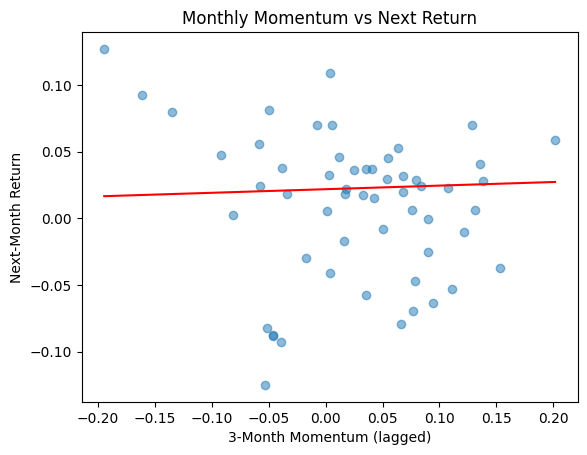

In [118]:
plt.scatter(df_monthly["momentum"], df_monthly["rets"], alpha=0.5)
plt.xlabel("3-Month Momentum (lagged)")
plt.ylabel("Next-Month Return")
plt.title("Monthly Momentum vs Next Return")

# Regression line
slope = model.params["momentum"]
intercept = model.params["const"]
x_vals = np.linspace(df_monthly["momentum"].min(), df_monthly["momentum"].max(), 100)
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color="red")
plt.show()

**Summary of scatter plot:** Weak to no relationship between monthly momentum and next return

### Backtesting Monthly Trading Strategies

Using the monthly regression predictions, I construct and test two simple trading rules:

1. **Strategy 1 (Long/Short):**  
   - Go **long** if the predicted return > 0  
   - Go **short** if the predicted return < 0  

2. **Strategy 2 (Long-Only):**  
   - Go **long** if the predicted return > 0  
   - Stay in **cash** (0 exposure) if the predicted return ≤ 0  

I then compute strategy returns (lagged to avoid lookahead bias) and compare the cumulative performance of both strategies against a simple **buy & hold** benchmark.

<Axes: title={'center': 'Buy & Hold vs Strategy (monthly)'}, xlabel='Date'>

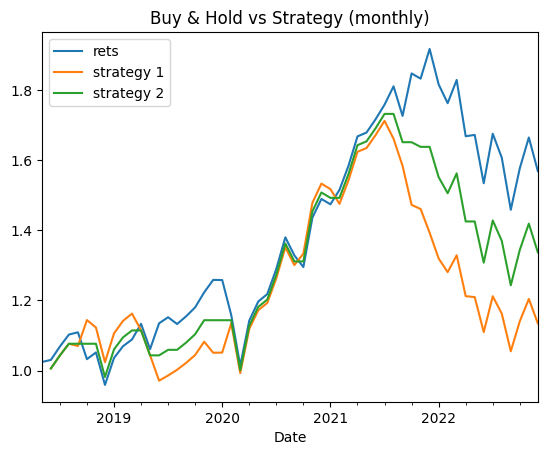

In [134]:
# Predict monthly returns
df_monthly["pred"] = model.predict(X_m)

# Trading rule 1: long if prediction > 0, short if prediction < 0
df_monthly["position_1"] = np.where(df_monthly["pred"] > 0, 1, -1)

# Trading rule 2: Long only
df_monthly["position_2"] = np.where(df_monthly["pred"] > 0, 1, 0)  

# Strategy 1 returns
df_monthly["strategy 1"] = df_monthly["position_1"].shift(1) * df_monthly["rets"]  # shift to avoid lookahead bias

# Strategy 2 returns
df_monthly["strategy 2"] = df_monthly["position_2"].shift(1) * df_monthly["rets"]  # shift to avoid lookahead bias

# Cumulative returns
(df_monthly[["rets", "strategy 1", "strategy 2"]] + 1).cumprod().plot(title="Buy & Hold vs Strategy (monthly)")


**Summary**

- **Buy & Hold (blue):** Continues to outperform over the sample period, reaching the highest cumulative return.  


- **Strategy 1 (orange, long/short):**  
  - Performs well at times, but suffers from **short positions** in a generally rising market.  
  - This causes significant underperformance after 2021.  

- **Strategy 2 (green, long-only):**  
  - Tracks buy & hold more closely, with less downside risk than Strategy 1.  
  - However, it still fails to consistently outperform buy & hold, as the model’s predictive signals are weak.  

**Interpretation**
- Shorting hurts performance when applied to SPY, which has a strong long-term upward drift.  
- Long-only models are more robust, but the regression-based signals do not add much value compared to simply holding the index.  

## Bayesian Extension

To improve upon the simple OLS regression, I extend the model using Bayesian Ridge Regression.
Unlike OLS, which gives point estimates for coefficients, Bayesian Ridge places priors on the regression weights and updates them using the data.

 - This approach automatically balances fit vs regularization through the priors.

 - It provides uncertainty estimates for the coefficients.

 - I test the Bayesian model on the same features (momentum, volatility, RSI) and compare its trading strategy against buy & hold and OLS-based strategies.

### Bayesian Ridge Regression Setup

We extend the model using **Bayesian Ridge Regression**, which places priors on regression coefficients and hyperparameters.

- **Prior on coefficients**  
$$
p(\beta \mid \lambda) = \mathcal{N}(0, \lambda^{-1} I)
$$  

- **Priors on hyperparameters**  
$$
p(\alpha) = \text{Gamma}(a_\alpha, b_\alpha), \quad 
p(\lambda) = \text{Gamma}(a_\lambda, b_\lambda)
$$  

- **Posterior for coefficients (by Bayes’ theorem):**  
$$
\beta \mid X, y, \alpha, \lambda \sim \mathcal{N}(\mu, \Sigma)
$$  

with  
$$
\Sigma = (\lambda I + \alpha X^\top X)^{-1}, 
\quad \mu = \alpha \Sigma X^\top y
$$

**Intuition:**
- Bayesian Ridge automatically balances **fit vs. regularization**.  
- The Gaussian prior shrinks coefficients toward zero (like Ridge regression).  
- The Gamma priors on noise precision ($\alpha$) and coefficient precision ($\lambda$) allow the model to adaptively control how much shrinkage is applied.  
- This yields more stable estimates and provides **uncertainty quantification** for the regression weights.


**Install packages**

In [139]:
!pip install scikit-learn

   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/8.7 MB 6.3 MB/s eta 0:00:02
   ---------- ----------------------------- 2.4/8.7 MB 6.3 MB/s eta 0:00:02
   ---------------- ----------------------- 3.7/8.7 MB 6.1 MB/s eta 0:00:01
   ---------------------- ----------------- 5.0/8.7 MB 6.1 MB/s eta 0:00:01
   ---------------------------- ----------- 6.3/8.7 MB 6.1 MB/s eta 0:00:01
   ---------------------------------- ----- 7.6/8.7 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 6.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


**Bayesian Ridge Regression: Model Setup & Predictions**

In [140]:
from sklearn.linear_model import BayesianRidge

# Features (X) and target (y)
X = df_monthly[["momentum", "volatility", "rsi"]]
y = df_monthly["rets"]

# 1. Fit Bayesian regression
bayes = BayesianRidge()
bayes.fit(X, y)

# 2. Predictions
df_monthly["pred_bayes"] = bayes.predict(X)


### Predictive Uncertainty in Bayesian Ridge

In Bayesian Ridge Regression, predictions come with **uncertainty estimates** because the regression coefficients $\beta$ follow a posterior distribution with covariance $\Sigma$.

For a new feature vector $x_i$, the **predictive variance** is:

$
\text{Var}[\hat{y}_i] = \frac{1}{\alpha} + x_i^\top \Sigma x_i
$

- $\alpha$: precision (inverse variance) of the noise  
- $\Sigma$: posterior covariance of coefficients (\(n_{\text{features}} \times n_{\text{features}}\))  
- $x_i$: feature vector for sample \(i\)  

Thus, predictions include both **data noise** $1/\alpha$ and **parameter uncertainty** $x_i^\top \Sigma x_i$.

I now compute this quantity in code to obtain a **95% prediction interval** for each month.

In [156]:
# Posterior covariance of coefficients
Sigma = bayes.sigma_   # shape (n_features, n_features)
alpha = bayes.alpha_   # precision (inverse variance)

# Predictive variance for each sample
pred_var = (1.0 / alpha) + np.einsum("ij,jk,ik->i", X.values, Sigma, X.values)
pred_std = np.sqrt(pred_var)  # predictive standard deviation

# uncertainty interval
df_monthly["y_lower"] = df_monthly["pred_bayes"] - 1.96 * pred_std # +/- 1.96 standard deviations of the mean for 95% CI
df_monthly["y_upper"] = df_monthly["pred_bayes"] + 1.96 * pred_std

# Keep only actual returns, predictions, and intervals
df_results = df_monthly[["pred_bayes", "y_lower", "y_upper"]]

df_results.head()

,pred_bayes,y_lower,y_upper
Date,,,
2018-05-31,0.013035,-0.098088,0.124158
2018-06-30,0.013994,-0.096739,0.124727
2018-07-31,0.024171,-0.083168,0.131511
2018-08-31,0.003711,-0.111779,0.119201
2018-09-30,-0.003242,-0.122627,0.116143


**Take-away:** I am ~95% confident the true value of predicted return (pred_bayes) lies within the given interval for each sample (row). 

### Trading Strategy with Bayesian Predictions  

I now implement a long-only trading strategy based on Bayesian Ridge predictions.  
If the model predicts a positive return, I take a long position; otherwise, I stay out of the market.  
The resulting strategy is compared against Buy & Hold and earlier OLS-based strategies.  

<Axes: title={'center': 'Buy & Hold vs Strategy (monthly)'}, xlabel='Date'>

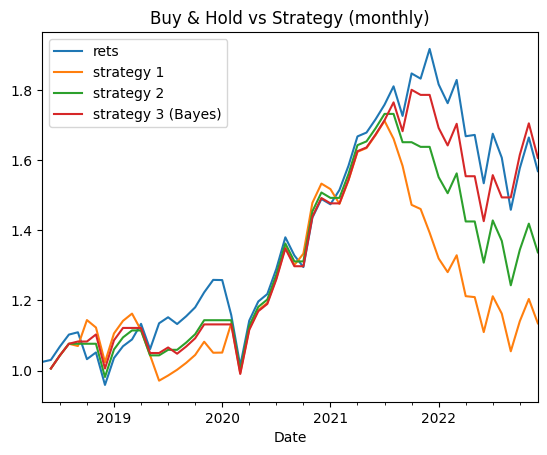

In [158]:
# Trading rule Long only (Bayes)
df_monthly["position_3"] = np.where(df_monthly["pred_bayes"] > 0, 1, 0)  

# Strategy 3 (Bayes) returns
df_monthly["strategy 3 (Bayes)"] = df_monthly["position_3"].shift(1) * df_monthly["rets"]  # shift to avoid lookahead bias

# Cumulative returns
(df_monthly[["rets", "strategy 1", "strategy 2", "strategy 3 (Bayes)"]] + 1).cumprod().plot(title="Buy & Hold vs Strategy (monthly)")

**Takeaway**:  
- Buy & Hold (blue) still delivers the highest cumulative returns.  
- Strategy 1 (orange, long/short OLS) underperforms due to short exposure.  
- Strategy 2 (green, long-only OLS) tracks better but lags after 2021.  
- Strategy 3 (red, long-only **Bayesian**) improves over Strategy 2, showing closer performance to Buy & Hold, though it still fails to consistently outperform.  

## Project Conclusion

In this project, I built a simple **quantitative finance pipeline** using Python and Yahoo Finance data:

1. **Data collection**: Pulled daily and monthly price data for SPY.  
2. **Feature engineering**: Created momentum, volatility, and RSI features at both daily and monthly horizons.  
3. **Modeling**: Fit linear regression models (OLS) and extended with **Bayesian Ridge Regression** to test the predictive power of these features.  
4. **Backtesting**: Translated model predictions into trading strategies (long/short, long-only, Bayesian long-only) and compared them against a buy & hold benchmark.  

---

## Key Takeaways  

- **Daily predictions are very noisy.**  
  OLS regression explained almost none of the variation in daily returns.  
  Strategies built on daily predictions underperformed significantly.  

- **Monthly signals performed better, but remain weak.**  
  At the monthly horizon, volatility and momentum showed more explanatory power, but predictive ability was still limited.  

- **Bayesian Ridge adds interpretability.**  
  By incorporating priors and producing **uncertainty estimates**, Bayesian regression improved stability over OLS.  
  The Bayesian strategy tracked buy & hold more closely than OLS-based strategies, but still struggled to consistently outperform.  

- **Buy & Hold remains hard to beat.**  
  Both OLS and Bayesian-based strategies failed to consistently outperform the benchmark, especially after transaction costs are considered.  
